In [1]:
import numpy as np
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# ----- Data Loading -----
def load_dataset(base_path):
    X, y = [], []
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(base_path, label_name)
        for file in glob(os.path.join(folder, "*.npy")):
            arr = np.load(file)
            if arr.shape == (30, 51):  # Check for correct shape
                X.append(arr)
                y.append(label_val)
    return np.array(X), np.array(y)

# Paths
base_train = '/kaggle/input/fall-dataset2/train'
base_val   = '/kaggle/input/fall-dataset2/val'
base_test  = '/kaggle/input/fall-dataset2/test'

# Load datasets
X_train, y_train = load_dataset(base_train)
X_val,   y_val   = load_dataset(base_val)
X_test,  y_test  = load_dataset(base_test)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

Train: (40895, 30, 51) (40895,)
Val:   (8764, 30, 51) (8764,)
Test:  (8764, 30, 51) (8764,)


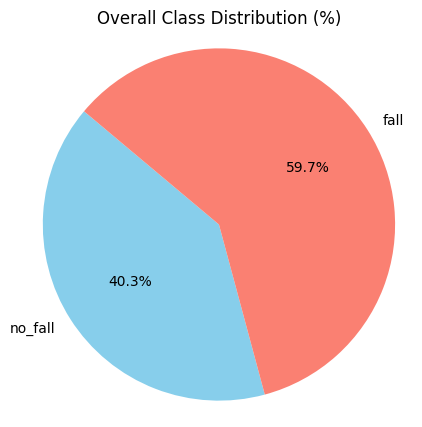

In [3]:
y_all = np.concatenate([y_train, y_val, y_test])
unique, counts = np.unique(y_all, return_counts=True)

# Pie chart
labels = ["no_fall" if l == 0 else "fall" for l in unique]
colors = ["skyblue", "salmon"]
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Overall Class Distribution (%)")
plt.axis("equal")
plt.show()

In [4]:
def normalize_sequences(sequences):
    sequences_norm = []
    for seq in sequences:
        seq_norm = np.zeros_like(seq)
        for i in range(17):  # each keypoint
            x = seq[:, i * 3 + 0] / 1920  # normalize x
            y = seq[:, i * 3 + 1] / 1080  # normalize y
            c = seq[:, i * 3 + 2]         # keep confidence as-is
            seq_norm[:, i * 3 + 0] = x
            seq_norm[:, i * 3 + 1] = y
            seq_norm[:, i * 3 + 2] = c
        sequences_norm.append(seq_norm)
    return np.array(sequences_norm)

# Normalize datasets
X_train_norm = normalize_sequences(X_train)
X_val_norm   = normalize_sequences(X_val)
X_test_norm  = normalize_sequences(X_test)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, classification_report, confusion_matrix
import pandas as pd

# Focal Loss
import tensorflow as tf
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        bce_exp = K.exp(-bce)
        loss = alpha * K.pow((1 - bce_exp), gamma) * bce
        return K.mean(loss)
    return focal_loss_fixed

# Compute class weights
class_weights = compute_class_weight(class_weight={0: 1.1, 1: 1.2}, classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Custom Callback to track F1 scores
class F1Callback(Callback):
    def __init__(self, val_data):
        self.val_data = val_data
        self.best_macro_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(self.val_data[0]) >= 0.5).astype(int)
        f1_fall = f1_score(self.val_data[1], val_pred)
        f1_no_fall = f1_score(self.val_data[1], val_pred, pos_label=0)
        macro_f1 = (f1_fall + f1_no_fall) / 2
        print(f"\nEpoch {epoch + 1}: F1 (fall): {f1_fall:.4f}, F1 (no_fall): {f1_no_fall:.4f}, Macro F1: {macro_f1:.4f}")

        if macro_f1 > self.best_macro_f1:
            self.best_macro_f1 = macro_f1
            self.model.save_weights("best_macro_f1.weights.h5")

# Build model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(30, 51)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


model.compile(loss=focal_loss(gamma=2.0, alpha=0.25), optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()


2025-05-12 14:47:01.925345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747061222.159243      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747061222.231559      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 14:47:16.617310: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mod

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,673 (393.25 KB)

 Trainable params: 100,673 (393.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
f1_monitor = F1Callback(val_data=(X_val_norm, y_val))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, f1_monitor],
    class_weight=class_weight_dict
)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Epoch 1: F1 (fall): 0.7448, F1 (no_fall): 0.6187, Macro F1: 0.6817
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.6636 - loss: 0.0439 - val_accuracy: 0.6942 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Epoch 2: F1 (fall): 0.7663, F1 (no_fall): 0.5097, Macro F1: 0.6380
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6797 - loss: 0.0415 - val_accuracy: 0.6835 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Epoch 3: F1 (fall): 0.7756, F1 (no_fall): 0.4683, Macro F1: 0.6219
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6911 - loss: 0.0397 - val_accuracy: 0.6844 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Epoch 4: F1 (fall): 0.7712, F1 (no_fall): 0.5882, Macro F1: 0.6797
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6857 - loss: 0.0401 - va

In [7]:
# Load best weights
model.load_weights("best_macro_f1.weights.h5")
# Predict
y_val_pred = (model.predict(X_val_norm) >= 0.5).astype(int)
y_test_pred = (model.predict(X_test_norm) >= 0.5).astype(int)

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [8]:
# Classification reports
def get_metrics_report(y_true, y_pred, labels):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    f2 = fbeta_score(y_true, y_pred, beta=2, average=None)
    support = [sum((y_true == i)) for i in range(len(labels))]

    df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'F2-score': f2,
        'Support': support
    }, index=labels)
    return df

target_names = ['no_fall', 'fall']
val_report_df = get_metrics_report(y_val, y_val_pred, target_names)
test_report_df = get_metrics_report(y_test, y_test_pred, target_names)

print("\nCustom Validation Metrics Report:")
print(val_report_df.round(4))
print("\nCustom Test Metrics Report:")
print(test_report_df.round(4))

# Save to CSV
val_report_df.to_csv("validation_metrics_report.csv")
test_report_df.to_csv("test_metrics_report.csv")
print("\nSaved validation and test metric reports to CSV.")


Custom Validation Metrics Report:
         Precision  Recall  F1-score  F2-score  Support
no_fall      0.639  0.7596    0.6941    0.7320     3532
fall         0.814  0.7102    0.7586    0.7288     5232

Custom Test Metrics Report:
         Precision  Recall  F1-score  F2-score  Support
no_fall     0.6216  0.7613    0.6844    0.7286     3532
fall        0.8100  0.6871    0.7435    0.7086     5232

Saved validation and test metric reports to CSV.


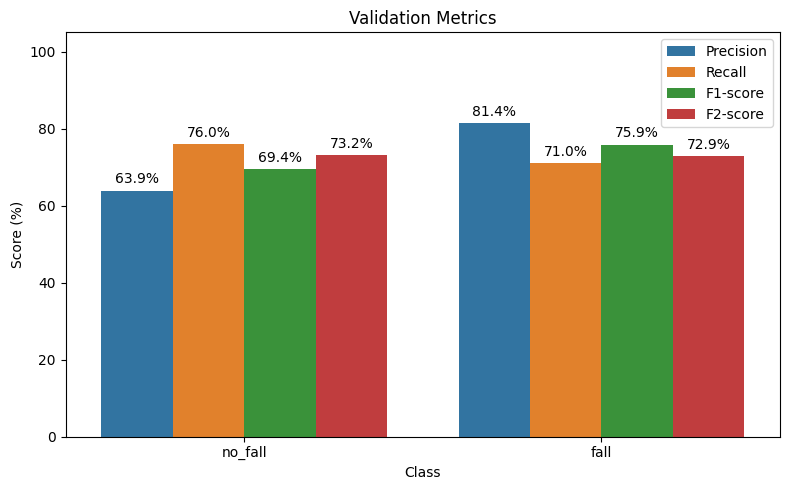

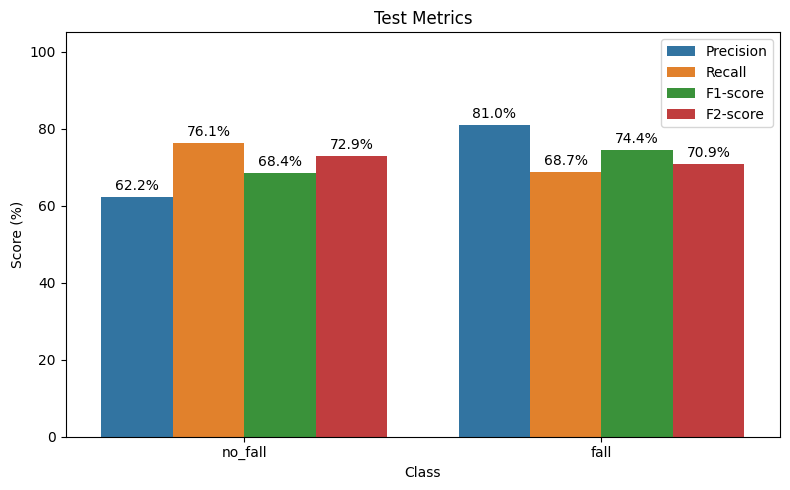

In [9]:
# Visualization function
def plot_metrics(df, title):
    df_plot = df.drop(columns=['Support']).reset_index()
    df_plot = df_plot.melt(id_vars='index', var_name='Metric', value_name='Score')
    df_plot['Score'] = df_plot['Score'] * 100

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_plot, x='index', y='Score', hue='Metric')
    plt.title(title)
    plt.ylim(0, 105)
    plt.xlabel("Class")
    plt.ylabel("Score (%)")
    plt.legend(loc='upper right')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)
    plt.tight_layout()
    plt.show()

plot_metrics(val_report_df, "Validation Metrics")
plot_metrics(test_report_df, "Test Metrics")

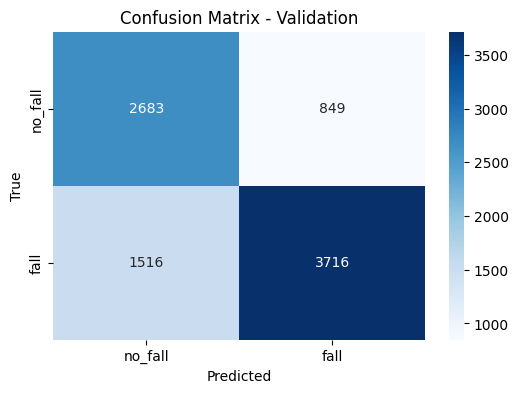

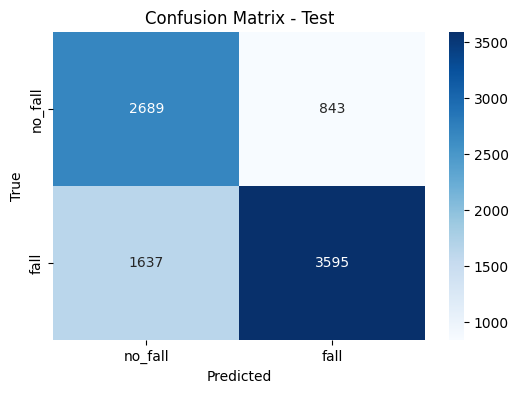

In [11]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm_val, "Confusion Matrix - Validation")
plot_confusion_matrix(cm_test, "Confusion Matrix - Test")